In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors

## set up example

In [2]:
thrust = torch.tensor([0., 0., 0., 0.99, 0.99,
          0.97373036, 0.92826162, 0.89210543, 0.86100905, 0.835423,
          0.81237673, 0.79225789, 0.77584769, 0.7629228, 0.76156073,
          0.76261984, 0.76169723, 0.75232027, 0.74026851, 0.72987175,
          0.70701647, 0.54054532, 0.45509459, 0.39343381, 0.34250785,
          0.30487242, 0.27164979, 0.24361964, 0.21973831, 0.19918151,
          0.18131868, 0.16537679, 0.15103727, 0.13998636, 0.1289037,
          0.11970413, 0.11087113, 0.10339901, 0.09617888, 0.09009926,
          0.08395078, 0.0791188, 0.07448356, 0.07050731, 0.06684119,
          0.06345518, 0.06032267, 0.05741999, 0.05472609, 0.,
          0.])

wind_speed = torch.tensor([0.,  2.,  2.5,  3.,  3.5,  4.,  4.5,  5.,  5.5,
              6.,  6.5,  7.,  7.5,  8.,  8.5,  9.,  9.5, 10.,
              10.5, 11., 11.5, 12., 12.5, 13., 13.5, 14., 14.5,
              15., 15.5, 16., 16.5, 17., 17.5, 18., 18.5, 19.,
              19.5, 20., 20.5, 21., 21.5, 22., 22.5, 23., 23.5,
              24., 24.5, 25., 25.01, 25.02, 50.])

power = torch.tensor([0., 0., 0., 0.178085, 0.289075, 0.349022,
         0.384728, 0.406059, 0.420228, 0.428823, 0.433873, 0.436223,
         0.436845, 0.436575, 0.436511, 0.436561, 0.436517, 0.435903,
         0.434673, 0.43323, 0.430466, 0.378869, 0.335199, 0.297991,
         0.266092, 0.238588, 0.214748, 0.193981, 0.175808, 0.159835,
         0.145741, 0.133256, 0.122157, 0.112257, 0.103399, 0.095449,
         0.088294, 0.081836, 0.075993, 0.070692, 0.065875, 0.061484,
         0.057476, 0.053809, 0.050447, 0.047358, 0.044518, 0.0419,
         0.039483, 0., 0.])

air_density = 1.225 # same as `examples/inputs/gch.yaml`

generator_efficiency = 1.0
turbine_hub_height = 90.0
pP = 1.88
turbine_diameter = 126.0
TSR = 8.0

rloc = 0.5
turbine_radius = turbine_diameter / 2.0

# 6x6
# x_coord = torch.tensor([0.]*6 + [6.]*6 + [12.]*6 + [18.]*6 + [24.]*6 + [30.]*6) * turbine_diameter
# y_coord = torch.tensor([0., 3., 6., 9., 12., 15.]*6) * turbine_diameter

#4x4
# x_coord = torch.tensor([0., 0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 
#                         12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter,
#                         18.*turbine_diameter, 18.*turbine_diameter, 18.*turbine_diameter, 18.*turbine_diameter])

# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter])

#3x3
# x_coord = torch.tensor([0., 0., 0., 
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 
#                         12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter])

#3x1, 2x1, 1x1
# x_coord = torch.tensor([0., 0., 0., 
#                         6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter,
#                         0.])

#3x1, 2x1
# x_coord = torch.tensor([0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter,
#                         0., 3.*turbine_diameter,
#                         0.])

# 3x1, 3x1, 1x1, symmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         3.*turbine_diameter,])

# 3x1, 3x1, 1x1, asymmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0.])

# 4x1, 4x1, 2x1, asymmetric
# x_coord = torch.tensor([0., 0., 0., 0.,
#                         6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter, 6.*turbine_diameter,
#                         12.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter, 6.*turbine_diameter, 9.*turbine_diameter,
#                         0., 3.*turbine_diameter])

# 3x1, 1x1, 1x1, symmetric
# x_coord = torch.tensor([0., 0., 0.,
#                         6.*turbine_diameter, 
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         3.*turbine_diameter,
#                         3.*turbine_diameter,])

# 3x1, 1x1, 1x1, asymmetric
# x_coord = torch.tensor([0., 0., 0., 
#                         6.*turbine_diameter,
#                         12.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 6.*turbine_diameter,
#                         0.,
#                         0.])

# 1x1, 1x1, 3x1, asymmetric
# x_coord = torch.tensor([0.*turbine_diameter,
#                         6.*turbine_diameter,
#                         12.*turbine_diameter, 12.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([6.*turbine_diameter,
#                         6.*turbine_diameter,
#                         6.*turbine_diameter, 3.*turbine_diameter, 0.])

# 2x2
x_coord = torch.tensor([0., 6.*turbine_diameter, 
                        0., 6.*turbine_diameter])
y_coord = torch.tensor([6.*turbine_diameter, 6.*turbine_diameter,
                        0., 0.])

# 2x2 symmetric spacing
# x_coord = torch.tensor([0., 6.*turbine_diameter, 
#                         0., 6.*turbine_diameter])
# y_coord = torch.tensor([6.*turbine_diameter, 6.*turbine_diameter, 
#                         0., 0.])

# 2x1
# x_coord = torch.tensor([0., 3.*turbine_diameter])
# y_coord = torch.tensor([0., 0.])

# 2x1, 1x1
# x_coord = torch.tensor([0., 0., 6.*turbine_diameter])
# y_coord = torch.tensor([0., 3.*turbine_diameter, 3.*turbine_diameter])

# 1x1, 1x1, 1x1
# x_coord = torch.tensor([0., 6.*turbine_diameter, 12.*turbine_diameter])
# y_coord = torch.tensor([0., 0., 0.])

# 1x1, 1x1
# x_coord = torch.tensor([0., 6.*turbine_diameter])
# y_coord = torch.tensor([0., 0.*turbine_diameter])

nturbs = len(x_coord)
z_coord = torch.tensor([90.0] * nturbs)

y_ngrid = 3
z_ngrid = 3

# Wind parameters
ws_max = 8.0
wd_fixed = 270.
wd_max = 360.

specified_wind_height = 90.0
wind_shear = 0.12
wind_veer = 0.0
TI = 0.06

umin = torch.tensor([-25.]) # min allowed yaw angle (degrees)
umax = torch.tensor([25.]) # max allowed yaw angle (degrees)

# neural net params
model_config = dict({"n_turbines": nturbs, "hidden_dim": 128, "hidden_dim_d": 16})

# hyperparameters -> selected ad hoc; should do hyperparameter training
u_penalty = 10.
lr = .001
batch_size = 100
N_batches = 50
N_epochs = 10

## Functions

In [3]:
def cosd(angle):
    return torch.cos(torch.deg2rad(angle))

def sind(angle):
    return torch.sin(torch.deg2rad(angle))

def tand(angle):
    return torch.tan(torch.deg2rad(angle))

def interp(x, y, x_new):
    x_new_indices = torch.searchsorted(x, x_new)
    x_new_indices = x_new_indices.clip(1,len(x)-1)
    lo = x_new_indices - 1
    hi = x_new_indices
    x_lo = x[lo]
    x_hi = x[hi]
    y_lo = y[lo]
    y_hi = y[hi]
    slope = (y_hi - y_lo) / (x_hi - x_lo)
    return slope*(x_new - x_lo) + y_lo

def gaussian_function(U, C, r, n, sigma):
    return C * torch.exp(-1 * r ** n / (2 * sigma ** 2))

In [5]:
class DPCModel(nn.Module):
    def __init__(
        self,
        n_turbines: int,
        hidden_dim: int = 64,
        hidden_dim_d: int = 64,
        **kwargs
    ):
        super().__init__()
#         input_size = 2 # ws, wd
        input_size = 1 # wd
        self.input_layer = nn.Linear(input_size, hidden_dim)
#         self.hidden_layer_d = nn.Linear(hidden_dim, hidden_dim_d)
#         self.hidden_layer_d.eps = torch.nn.parameter.Parameter(torch.randn(hidden_dim_d))
#         self.hidden_layer_1 = nn.Linear(hidden_dim_d, hidden_dim)
        self.hidden_layer_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_layer_2 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_3 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_4 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_5 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_6 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_7 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_8 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_9 = nn.Linear(hidden_dim, hidden_dim)
#         self.hidden_layer_10 = nn.Linear(hidden_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, n_turbines)
        
        
    def forward(self, x):
        # x: state of system = torch.tensor([ws, wd])
        # u: control action (yaw angle for each turbine)
        u = F.relu(self.input_layer(x)) 
#         u = self.hidden_layer_d(u) # discont. layer
#         u = F.relu(u) + self.hidden_layer_d.eps * torch.sign(F.relu(u) + torch.sign(u) + 1.) # discont. AF
        u = F.relu(self.hidden_layer_1(u)) # hidden layer
        u = F.relu(self.hidden_layer_2(u)) # hidden layer
#         u = F.relu(self.hidden_layer_3(u)) # hidden layer
#         u = F.relu(self.hidden_layer_4(u)) # hidden layer
#         u = F.relu(self.hidden_layer_5(u)) # hidden layer
#         u = F.relu(self.hidden_layer_6(u)) # hidden layer
#         u = F.relu(self.hidden_layer_7(u)) # hidden layer
#         u = F.relu(self.hidden_layer_8(u)) # hidden layer
#         u = F.relu(self.hidden_layer_9(u)) # hidden layer
#         u = F.relu(self.hidden_layer_10(u)) # hidden layer
#         u = torch.sigmoid(self.output_layer(u))*2.2 - 1.1 # shift to allow exploration beyond constraints
        u = torch.sigmoid(self.output_layer(u))*2.-1. # output layer
#         u = F.relu(self.output_layer(u))
        return u

In [6]:
def get_control(ws, wd, inds_sorted):
    ## get control action ##
    # normalize features to range [0,1] by dividing ws by ws_max and wd by wd_max
#     x = torch.cat([ws/ws_max, wd/wd_max])
#     x = torch.cat([(wd-260.)/20.])
    x = torch.cat([wd/90.])
    u = model(x)
#     clipped_u = F.relu(u*umax-umin) + umin
#     clipped_u = -F.relu(-clipped_u + umax) + umax
    clipped_u = torch.clone(u)*umax
    clipped_u_sorted = clipped_u[inds_sorted.flatten()]
    return u, clipped_u, clipped_u_sorted

In [7]:
def get_turbine_mesh(wd):
    x_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    y_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))
    z_grid = torch.zeros((len(x_coord), y_ngrid, z_ngrid))

    angle = ((wd - 270) % 360 + 360) % 360

    x1, x2, x3 = x_coord, y_coord, z_coord

    pt = rloc * turbine_radius

    # linspace for an array; torch.linspace only takes scalar
    steps = torch.arange(y_ngrid).unsqueeze(-1) / (y_ngrid - 1)
    yt = (x2 - pt) + steps*2.*pt

    steps = torch.arange(z_ngrid).unsqueeze(-1) / (z_ngrid - 1)
    zt = (x3 - pt) + steps*2.*pt

    x_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * x_coord[:, None, None]
    y_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * yt.T[:, :, None]
    z_grid = torch.ones((len(x_coord), y_ngrid, z_ngrid)) * zt.T[:, None, :]

    # yaw turbines to be perpendicular to the wind direction
    wind_direction_i = angle[None, :, None, None, None, None]
    xoffset = x_grid - x1[:, None, None]
    yoffset = y_grid - x2[:, None, None]
    wind_cos = cosd(-wind_direction_i)
    wind_sin = sind(-wind_direction_i)
    x_grid = xoffset * wind_cos - yoffset * wind_sin + x1[:, None, None]
    y_grid = yoffset * wind_cos + xoffset * wind_sin + x2[:, None, None]

    mesh_x = x_grid
    mesh_y = y_grid
    mesh_z = z_grid

    # rotate turbine locations/fields to be perpendicular to wind direction
    x_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_x), torch.max(mesh_x)]))
    y_center_of_rotation = torch.mean(torch.stack([torch.min(mesh_y), torch.max(mesh_y)]))
    angle = ((wd[None, :, None, None, None, None] - 270) % 360 + 360) % 360
    x_offset = mesh_x - x_center_of_rotation
    y_offset = mesh_y - y_center_of_rotation
    mesh_x_rotated = (x_offset * cosd(angle) - y_offset * sind(angle) 
                      + x_center_of_rotation)
    mesh_y_rotated = (x_offset * sind(angle) + y_offset * cosd(angle) 
                      + y_center_of_rotation)
    x_coord_offset = (x_coord - x_center_of_rotation)[:, None, None]
    y_coord_offset = (y_coord - y_center_of_rotation)[:, None, None]
    x_coord_rotated = (x_coord_offset * cosd(angle)
        - y_coord_offset * sind(angle)
        + x_center_of_rotation)
    y_coord_rotated = (x_coord_offset * sind(angle)
        + y_coord_offset * cosd(angle)
        + y_center_of_rotation)
    inds_sorted = x_coord_rotated.argsort(axis=3)

    x_coord_rotated = torch.gather(x_coord_rotated, 3, inds_sorted)
    y_coord_rotated = torch.gather(y_coord_rotated, 3, inds_sorted)
#     z_coord_rotated = torch.gather(z_coord * np.ones((np.shape(x_coord_rotated))), 
#                                    3, inds_sorted)
    
    mesh_x_rotated = torch.take_along_dim(mesh_x_rotated, inds_sorted, 3)
    mesh_y_rotated = torch.take_along_dim(mesh_y_rotated, inds_sorted, 3)
#     mesh_z_rotated = torch.take_along_dim(mesh_z * np.ones((np.shape(mesh_x_rotated))), 
#                                           inds_sorted, 3)
    #inds_unsorted = x_coord_rotated.argsort(axis=3)
    
    return x_coord_rotated, y_coord_rotated, \
        mesh_x_rotated, mesh_y_rotated, mesh_z, \
        inds_sorted

In [8]:
def get_field_rotor(ws, wd, clipped_u, \
        x_coord_rotated, y_coord_rotated, 
        mesh_x_rotated, mesh_y_rotated, mesh_z, \
        inds_sorted):
    ## initialize flow field ##
    
    flow_field_u_initial = (ws[None, None, :, None, None, None] 
                        * (mesh_z / specified_wind_height) ** wind_shear) \
                        * np.ones((1, len(wd), 1, 1, 1, 1))

    ## initialize other field values ##
    u_wake = torch.zeros(np.shape(flow_field_u_initial))
    flow_field_u = flow_field_u_initial - u_wake
    turb_inflow_field = torch.ones(np.shape(flow_field_u_initial)) * flow_field_u_initial

    ## Initialize turbine values ##
    turb_TIs = torch.ones_like(x_coord_rotated) * TI
    ambient_TIs = torch.ones_like(x_coord_rotated) * TI
    yaw_angle = clipped_u.reshape(x_coord_rotated.shape)
    turbine_tilt = torch.ones_like(x_coord_rotated) * 0.0

    # Loop over turbines to solve wakes
    for i in range(len(x_coord)):
        turb_inflow_field = turb_inflow_field \
        * (mesh_x_rotated != x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]) \
        + (flow_field_u_initial - u_wake) \
        * (mesh_x_rotated == x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])

        turb_avg_vels = torch.pow(torch.mean(turb_inflow_field ** 3, dim=(4,5)), 1./3.)

        Ct = interp(wind_speed, thrust, turb_avg_vels)
        yaw_angle_flat = torch.squeeze(torch.squeeze(yaw_angle, dim=4), dim=4)
        Ct *= cosd(yaw_angle_flat) # effective thrust
        Ct = Ct * (Ct < 1.0) + 0.9999 * torch.ones_like(Ct) * (Ct >= 1.0)
        turb_Cts = Ct * (Ct > 0.0) + 0.0001 * torch.ones_like(Ct) * (Ct <= 0.0)

        turb_aIs = 0.5 / cosd(yaw_angle_flat) * (1 - torch.sqrt(1 - turb_Cts * cosd(yaw_angle_flat) + 1e-16))

        ## Wake deflection calculation ##
        yaw = yaw_angle # if no secondary steering    
        x_coord_rotated_i = x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        y_coord_rotated_i = y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_ti_i = turb_TIs[:, :, :, i, :, :][:, :, :, None, :, :]
        turbine_Ct_i = turb_Cts[:, :, :, i][:, :, :, None, None, None]
        yaw_i = yaw[:, :, :, i, :, :][:, :, :, None, :, :]
        neg_yaw_i = -1. * yaw_i # wake deflection has opposite sign convention
        
        ka = 0.38  # wake expansion parameter
        kb = 0.004  # wake expansion parameter
        alpha = 0.58  # near wake parameter
        beta = 0.077  # near wake parameter
        ad = 0.0  # natural lateral deflection parameter
        bd = 0.0  # natural lateral deflection parameter
        dm = 1.0

        U_local = flow_field_u_initial

        # initial velocity deficits
        uR = (U_local * turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)
              / (2.0 * (1 - torch.sqrt(1 - (turbine_Ct_i * cosd(turbine_tilt) * cosd(neg_yaw_i)) + 1e-16))))
        u0 = U_local * torch.sqrt(1 - turbine_Ct_i + 1e-16)

        # length of near wake
        x0 = (turbine_diameter
              * (cosd(neg_yaw_i) * (1 + torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16)))
              / (np.sqrt(2) * (4 * alpha * turbine_ti_i + 2 * beta * (1 - torch.sqrt(1 - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # wake expansion parameters
        ky = ka * turbine_ti_i + kb
        kz = ka * turbine_ti_i + kb

        C0 = 1 - u0 / flow_field_u_initial
        M0 = C0 * (2 - C0)
        E0 = C0 ** 2 - 3 * np.exp(1.0 / 12.0) * C0 + 3 * np.exp(1.0 / 3.0)

        # initial Gaussian wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        yR = mesh_y_rotated - y_coord_rotated_i
        xR = x_coord_rotated_i

        # yaw_i parameter (skew angle)
        theta_c0 = (dm * (0.3 * torch.deg2rad(neg_yaw_i) / cosd(neg_yaw_i)) 
                    * (1 - torch.sqrt(1 - turbine_Ct_i * cosd(neg_yaw_i) + 1e-16))) # skew angle in radians

        # yaw_i param (distance from centerline=initial wake deflection)
        # NOTE: use tan here since theta_c0 is radians
        delta0 = torch.tan(theta_c0) * (x0 - x_coord_rotated_i) 

        # deflection in the near wake
        delta_near_wake = ((mesh_x_rotated - xR) / (x0 - xR)) * delta0 \
            + (ad + bd * (mesh_x_rotated - x_coord_rotated_i))
        delta_near_wake = delta_near_wake * (mesh_x_rotated >= xR)
        delta_near_wake = delta_near_wake * (mesh_x_rotated <= x0)

        # deflection in the far wake
        sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
        sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
        sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
        sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

        ln_deltaNum = (1.6 + torch.sqrt(M0 + 1e-16)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) - torch.sqrt(M0 + 1e-16))
        ln_deltaDen = (1.6 - torch.sqrt(M0)) \
            * (1.6 * torch.sqrt(sigma_y * sigma_z / (sigma_y0 * sigma_z0) + 1e-16) + torch.sqrt(M0 + 1e-16))
        delta_far_wake = (delta0 + (theta_c0 * E0 / 5.2)
                          * torch.sqrt(sigma_y0 * sigma_z0 / (ky * kz * M0) + 1e-16)
                          * torch.log(ln_deltaNum / ln_deltaDen)
                          + (ad + bd * (mesh_x_rotated - x_coord_rotated_i)))
        delta_far_wake = delta_far_wake * (mesh_x_rotated > x0)
        deflection_field = delta_near_wake + delta_far_wake

        ## Calculate wake deficits ##
        # wake deflection
        delta = deflection_field

        # mask upstream wake
        xR = x_coord_rotated_i

        # mask upstream wake
        #   initial velocity deficits
        uR = U_local * turbine_Ct_i / (2.0 * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16)))
        u0 = U_local * torch.sqrt(1. - turbine_Ct_i + 1e-16)
        #   initial wake expansion
        sigma_z0 = turbine_diameter * 0.5 * torch.sqrt(uR / (U_local + u0) + 1e-16)
        sigma_y0 = sigma_z0 * cosd(neg_yaw_i) * cosd(torch.tensor(wind_veer))

        # quantity that determines when the far wake starts
        x0 = (turbine_diameter * (cosd(neg_yaw_i) * (1. + torch.sqrt(1. - turbine_Ct_i + 1e-16)))
              / (np.sqrt(2.) * (4. * alpha * turbine_ti_i + 2. * beta 
                                   * (1. - torch.sqrt(1. - turbine_Ct_i + 1e-16))))
              + x_coord_rotated_i)

        # velocity deficit in the near wake
        turb_u_wake = torch.zeros_like(U_local)
        near_wake_mask = (mesh_x_rotated > xR + 0.1) * (mesh_x_rotated < x0)
        if torch.sum(near_wake_mask):
            sigma_y = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_y0
            sigma_z = (((x0 - xR) - (mesh_x_rotated - xR)) / (x0 - xR)) * 0.501 * turbine_diameter \
                * torch.sqrt(turbine_Ct_i / 2. + 1e-16) + ((mesh_x_rotated - xR) / (x0 - xR)) * sigma_z0

            sigma_y = (sigma_y * (mesh_x_rotated >= xR) + torch.ones_like(sigma_y) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)
            sigma_z = (sigma_z * (mesh_x_rotated >= xR) + torch.ones_like(sigma_z) 
                       * (mesh_x_rotated < xR) * 0.5 * turbine_diameter)

            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * ((mesh_y_rotated - y_coord_rotated_i) - delta) ** 2
                 - 2 * b * ((mesh_y_rotated - y_coord_rotated_i) - delta) * ((mesh_z - turbine_hub_height))
                 + c * ((mesh_z - turbine_hub_height)) ** 2)

            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            turb_u_wake = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * near_wake_mask

        far_wake_mask = (mesh_x_rotated >= x0)
        if torch.sum(far_wake_mask):
            # wake expansion in the lateral (y) and the vertical (z)
            sigma_y = ky * (mesh_x_rotated - x0) + sigma_y0
            sigma_z = kz * (mesh_x_rotated - x0) + sigma_z0
            sigma_y = sigma_y * (mesh_x_rotated >= x0) + sigma_y0 * (mesh_x_rotated < x0)
            sigma_z = sigma_z * (mesh_x_rotated >= x0) + sigma_z0 * (mesh_x_rotated < x0)

            # velocity deficit outside the near wake
            wind_veer_tensor = torch.tensor(wind_veer)
            a = cosd(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + sind(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            b = -sind(2 * wind_veer_tensor) / (4 * sigma_y ** 2) + sind(2 * wind_veer_tensor) / (4 * sigma_z ** 2)
            c = sind(wind_veer_tensor) ** 2 / (2 * sigma_y ** 2) + cosd(wind_veer_tensor) ** 2 / (2 * sigma_z ** 2)
            r = (a * (mesh_y_rotated - y_coord_rotated_i - delta) ** 2
                 - 2 * b * (mesh_y_rotated - y_coord_rotated_i - delta) * (mesh_z - turbine_hub_height)
                 + c * (mesh_z - turbine_hub_height) ** 2)
            C = 1 - torch.sqrt(torch.clip(1 - (turbine_Ct_i * cosd(neg_yaw_i) 
                / (8.0 * sigma_y * sigma_z / turbine_diameter ** 2)), 0.0, 1.0) + 1e-16)

            # compute velocities in the far wake
            turb_u_wake1 = gaussian_function(U_local, C, r, 1, np.sqrt(0.5)) * far_wake_mask
            turb_u_wake += turb_u_wake1

        ## Perform wake/field combinations ##
        u_wake = torch.sqrt((u_wake ** 2) + ((turb_u_wake * flow_field_u_initial) ** 2) + 1e-16)
        flow_field_u = flow_field_u_initial - u_wake

        ## Calculate wake overlap for wake-added turbulence (WAT) ##
        area_overlap = torch.sum(turb_u_wake * flow_field_u_initial > 0.05, axis=(4, 5)) / (y_ngrid * z_ngrid)

        ## Calculate WAT for turbines ##
        # turbulence intensity calculation based on Crespo et. al.
        turbine_aI_i = turb_aIs[:, :, :, i][:, :, :, None, None, None]
        ti_initial = 0.1
        ti_constant = 0.5
        ti_ai = 0.8
        ti_downstream = -0.32

        # replace zeros and negatives with 1 to prevent nans/infs
        # keep downstream components; set upstream to 1.0
        delta_x = mesh_x_rotated - x_coord_rotated_i
        upstream_mask = (delta_x <= 0.1)
        downstream_mask = (delta_x > -0.1)
        delta_x = delta_x * downstream_mask + torch.ones_like(delta_x) * upstream_mask
        ti_calculation = (ti_constant * turbine_aI_i ** ti_ai * ambient_TIs ** ti_initial \
                          * (delta_x / turbine_diameter) ** ti_downstream)

        # mask the 1 values from above w/ zeros
        WAT_TIs = ti_calculation * downstream_mask

        ## Modify WAT by wake area overlap ##
        # TODO: will need to make the rotor_diameter part of this mask work for
        # turbines of different types
        downstream_influence_length = 15 * turbine_diameter
        ti_added = (area_overlap[:, :, :, :, None, None] * torch.nan_to_num(WAT_TIs, posinf=0.0) 
            * (x_coord_rotated > x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :])
            * (torch.abs(y_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :] - y_coord_rotated) 
               < 2 * turbine_diameter)
            * (x_coord_rotated <= downstream_influence_length
               + x_coord_rotated[:, :, :, i, :, :][:, :, :, None, :, :]))

        ## Combine turbine TIs with WAT
        turb_TIs = torch.maximum(torch.sqrt(ti_added ** 2 + ambient_TIs ** 2 + 1e-16), turb_TIs,)    
        
    return flow_field_u, yaw_angle

In [9]:
def get_power(flow_field_u, x_coord_rotated, yaw_angle):
    ## power calculation (based on main floris branch) ##
    # omitted fCp_interp b/c interp power from wind_speed to wind_speed so does nothing...
    rotor_area = torch.pi * turbine_radius ** 2.0
    inner_power = 0.5*rotor_area*power*generator_efficiency*wind_speed**3

    # omiting some lines here b/c assuming all turbines have same type
    # ix_filter not implemented

    # Compute the yaw effective velocity
    pPs = torch.ones_like(x_coord_rotated) * 1.88 # `turbine_library/nrel_5MW.yaml`
    pW = pPs / 3.0  # Convert from pP to w
    axis = tuple([4 + i for i in range(flow_field_u.ndim - 4)])
    average_velocity = torch.pow(torch.mean(flow_field_u ** 3, axis=axis), 1./3.).reshape(yaw_angle.shape)
    yaw_effective_velocity = ((air_density/1.225)**(1/3)) * average_velocity * cosd(yaw_angle) ** pW

    # Power produced by a turbine adjusted for yaw and tilt. Value given in kW
    p = 1.225 * interp(wind_speed, inner_power, yaw_effective_velocity) / 1000.0

    # negative sign on power b/c good -> want to minimize
    return p

In [10]:
# def test_power(ws_test, wd, test_powers):
#     test_power = 0.
#     for ws in ws_test:
#         x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
#             mesh_y_rotated, mesh_z, inds_sorted = get_turbine_mesh(wd)
#         u, clipped_u = get_control(ws, wd, inds_sorted)
#         flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u, \
#             x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
#             mesh_y_rotated, mesh_z, inds_sorted)
#         p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
#         test_power += -torch.sum(p)
#     test_power /= len(ws_test)
#     test_powers.append(test_power.detach().numpy())

In [11]:
# def test_power(ws, wd_test, test_powers):
#     test_power = 0.
#     for wd in wd_test:
#         x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
#             mesh_y_rotated, mesh_z, inds_sorted = get_turbine_mesh(wd)
#         u, clipped_u = get_control(ws, wd, inds_sorted)
#         flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u, \
#             x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
#             mesh_y_rotated, mesh_z, inds_sorted)
#         p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
#         test_power += -torch.log(torch.sum(p))
        
#     test_power /= len(wd_test)
#     test_powers.append(test_power.detach().numpy())

In [12]:
def test_power(ws, wd_test, test_powers):
    for i in range(len(wd_test)):
        wd = wd_test[i]
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = get_turbine_mesh(wd)
        u, clipped_u, clipped_u_sorted = get_control(ws, wd, inds_sorted)
        flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted)
        p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
        test_power = torch.sum(p)
        
        test_powers[i].append(test_power.detach().numpy())
        
        ws = torch.tensor([8.])

#         print("wd: ", wd)
#         print("unrotated u: ", np.round((u*umax).detach().numpy(), 1))
#         print("")

## Training

epoch: 1/10.
batch: 5/50.


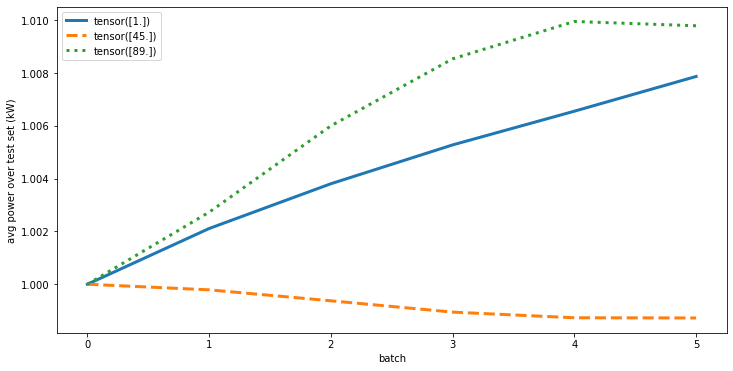

batch: 10/50.


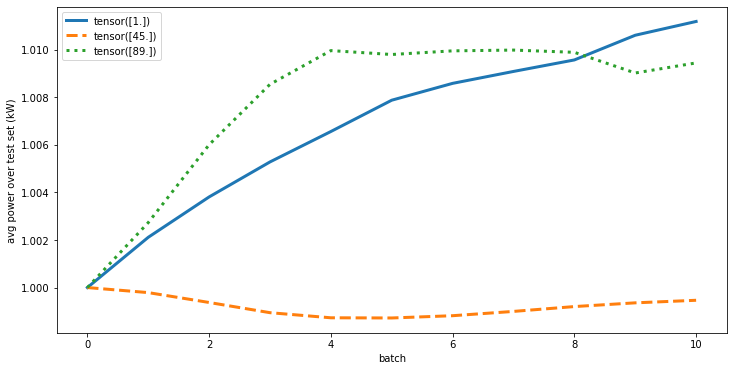

batch: 15/50.


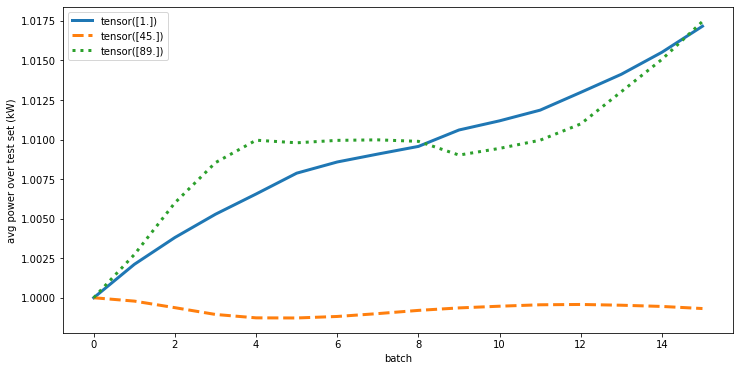

KeyboardInterrupt: 

In [14]:
# generate training data
# ws_training = torch.rand((N_batches, batch_size, 1)) * ws_max # ws from [0, ws_max]; m/s
wd_training = torch.rand((N_batches, batch_size, 1)) * 89. # vary wd from 0 to 89
# wd_training = wd_fixed + .1*(torch.rand((N_batches, batch_size, 1)) -.5) # wd varies around wd_fixed

# init DPC model
model = DPCModel(**model_config)

# init training
opt = torch.optim.Adam(model.parameters(), lr=lr)

opt_losses = []
u_viol_losses = []
power_losses = []

# evaluate and save performance of untrained model on test set
# note: test set only used to evaluate performance; not used for training
# ws_test = torch.tensor([[4.], [5.], [6.], [7.], [8.]])
ws_test = torch.tensor([ws_max])
# wd_test = torch.tensor([wd_fixed])
# wd_test = torch.tensor([[0.], [20.], [45.], [60.]])
# test_powers = [[], [], [], []]

wd_test = torch.tensor([[1.], [45.], [89.]])
# wd_test = torch.tensor([[0.], [90.], [180.], [270.]])
# wd_test = torch.tensor([[46.]])
test_powers = [[], [], [], []]
test_power(ws_test, wd_test, test_powers) # modifies test_powers

# for g in opt.param_groups:
#     g['lr'] = 0.001

# train
for epoch in range(N_epochs):
    print("epoch: %d/%d."%(epoch+1,N_epochs))
    
    # reorder samples to randomize data in batches
    perm_i = torch.randperm(N_batches)
    perm_j = torch.randperm(batch_size)
    wd_training_ij = wd_training[perm_i][:,perm_j]
    
    for batch in range(N_batches):
        opt_loss = 0.
        u_viol_loss = 0.
        power_loss = 0.
        ws_all = []
        wd_all = []
        u_all = []
        clipped_u_all = []

        # forward pass
        for sample in range(batch_size):
            ws = torch.tensor([ws_max])
            wd = wd_training_ij[batch, sample]

            ws_all.append(ws.detach().numpy())
            wd_all.append(wd.detach().numpy())

            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted = get_turbine_mesh(wd)

            u, clipped_u, clipped_u_sorted = get_control(ws, wd, inds_sorted)

            flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
                x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
                mesh_y_rotated, mesh_z, inds_sorted)

            p = get_power(flow_field_u, x_coord_rotated, yaw_angle)

            power_cost = -torch.sum(p)
            u_all.append(u.detach().numpy())
            clipped_u_all.append((clipped_u).detach().numpy())

            # cost from soft constraints (violating bounds on yaw angle)
            u_viol_lower = F.relu(umin - u*umax)
            u_viol_upper = F.relu(u*umax - umax)

            u_viol_cost = u_penalty * torch.sum(torch.sqrt(u_viol_lower.pow(2) + u_viol_upper.pow(2) + 1e-16))
    #         if torch.max(u*umax > umax):
    #             print("u > umax", u_viol_upper)
    #         if torch.max(u*umax < umin):
    #             print("u < umin", torch.sum(u_viol_lower), u_viol_cost)
            # total cost
            total_cost = u_viol_cost + power_cost

            # sum over data in batch
            opt_loss += total_cost
            u_viol_loss += u_viol_cost
            power_loss += power_cost

    #     batch_size = len(wd_test)
        opt_loss /= batch_size
        u_viol_loss /= batch_size
        power_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()

        opt.step()

        opt_losses.append(opt_loss.detach().numpy())
        u_viol_losses.append(u_viol_loss.detach().numpy())
        power_losses.append(power_loss.detach().numpy())

        test_power(ws_test, wd_test, test_powers) # modifies test_powers

        if (batch+1) % 5 == 0:
            print("batch: %d/%d."%(batch+1, N_batches))
    #         print("test power: ", test_powers[0][-1])
    #         print("")

            plt.plot(np.array(test_powers[0]/test_powers[0][0]), label=str(wd_test[0]), 
                     color='tab:blue', linestyle='-', linewidth=3)
            plt.plot(np.array(test_powers[1]/test_powers[1][0]), label=str(wd_test[1]), 
                     color='tab:orange', linestyle='--', linewidth=3)
            plt.plot(np.array(test_powers[2]/test_powers[2][0]), label=str(wd_test[2]), 
                     color='tab:green', linestyle=':', linewidth=3)
    #         plt.plot(np.array(test_powers[3]/test_powers[3][0]), label=str(wd_test[3]), 
    #                  color='tab:grey', linestyle='-.', linewidth=3)

    #         plt.plot(-np.array(opt_losses), linewidth=3)
            plt.xlabel('batch')
            plt.ylabel('avg power over test set (kW)')
            fig = plt.gcf()
            fig.set_size_inches(12,6)
            plt.legend()
            plt.show()

In [182]:
ws = torch.tensor([8.])

for wd in torch.tensor([1., 45., 89.]):
    wd = torch.tensor([wd])
    u, clipped_u, clipped_u_sorted = get_control(ws, wd, inds_sorted)
    print("wd: ", wd)
    print("unrotated u: ", np.round((u*umax).detach().numpy(), 1))

    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        get_turbine_mesh(wd)

    flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted)

    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    print("power: ", np.round(torch.sum(p).detach().numpy(), 0))
    print("")

wd:  tensor([1.])
unrotated u:  [24.4 24.1  0.1 -0.1]
power:  4950.0

wd:  tensor([45.])
unrotated u:  [ 0.1  6.9 -0.  -0. ]
power:  5881.0

wd:  tensor([89.])
unrotated u:  [ -0.4 -23.8  -1.1 -22.9]
power:  4592.0



In [151]:
ws = torch.tensor([8.])
wd = torch.tensor([45.])

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    get_turbine_mesh(wd)

u = torch.tensor([0., -20., 0., 0.])
clipped_u_sorted = u[inds_sorted.flatten()]
print("wd: ", wd)
print("unrotated u: ", np.round(u.detach().numpy(), 1))

flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)

p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("power: ", np.round(torch.sum(p).detach().numpy(), 0))
print("")

wd:  tensor([45.])
unrotated u:  [  0. -20.   0.   0.]
power:  5932.0



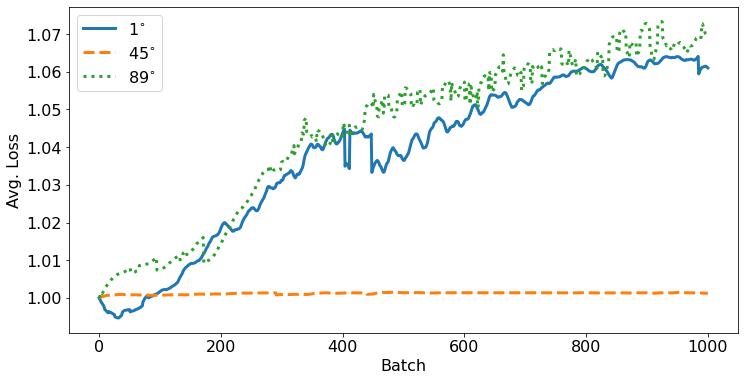

In [46]:
plt.rcParams.update({'font.size': 16})
plt.plot(np.array(test_powers[0]/test_powers[0][0]), label=r'$1^{\circ}$', 
         color='tab:blue', linestyle='-', linewidth=3)
plt.plot(np.array(test_powers[1]/test_powers[1][0]), label=r'$45^{\circ}$', 
         color='tab:orange', linestyle='--', linewidth=3)
plt.plot(np.array(test_powers[2]/test_powers[2][0]), label=r'$89^{\circ}$', 
         color='tab:green', linestyle=':', linewidth=3)
# plt.plot(np.array(test_powers[3]/test_powers[3][0]), label=r'$270^{\circ}$', 
#          color='tab:grey', linestyle='-.', linewidth=3)
plt.xlabel('Batch')
plt.ylabel('Avg. Loss')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.legend()
plt.show()

In [36]:
model.hidden_layer_d.eps

Parameter containing:
tensor([ 0.5510, -1.6927,  0.3860,  1.5222, -0.7359,  1.1394,  1.7611,  2.1224,
         0.7970, -0.5777, -0.0228,  1.4928, -0.7154,  0.3315, -0.5207, -0.2201],
       requires_grad=True)

In [ ]:
ws = torch.tensor([8.])
wd = torch.tensor([280.])

x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    get_turbine_mesh(wd)

clipped_u = torch.tensor([0., 0., 
                          0., 0.])
clipped_u_sorted = clipped_u[inds_sorted]
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("u: ", np.round((clipped_u).detach().numpy(), 1))
print("power: ", np.round(torch.sum(p).detach().numpy(), 0))
print("")

clipped_u = torch.tensor([15., 0., 
                          15., 0.])
clipped_u_sorted = clipped_u[inds_sorted]
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("u: ", np.round((clipped_u).detach().numpy(), 1))
print("power: ", np.round(torch.sum(p).detach().numpy(), 0))
print("")

u, clipped_u, clipped_u_sorted = get_control(ws, wd, inds_sorted)
flow_field_u, yaw_angle = get_field_rotor(ws, wd, clipped_u_sorted, \
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted)
p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
print("u: ", np.round((u*umax).detach().numpy(), 1))
print("power: ", np.round(torch.sum(p).detach().numpy(), 0))
print("")

In [ ]:
# power for test set from FLORIS model (baseline and optimized)
# FLORIS_baseline = (4483. + 2948. + 1771. + 923. + 364.)/5.
# FLORIS_opt = (4662. + 3094. + 1882. + 1003. + 406.)/5.

plt.rcParams.update({'font.size': 16})
plt.plot(-np.array(test_powers), label='DPC', color='tab:blue', linestyle='-', linewidth=3)
# plt.axhline(FLORIS_opt, label='lookup table', color='tab:orange', linestyle='--', linewidth=3)
# plt.axhline(FLORIS_baseline, label='baseline', color='tab:green', linestyle=':', linewidth=3)
plt.xlabel('epoch')
plt.ylabel('avg power over test set (kW)')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()

In [ ]:
# double check that no gradients in neural net are nan
for vals in [model.input_layer.weight, model.hidden_layer.weight, model.output_layer.weight, 
 model.input_layer.bias, model.hidden_layer.bias, model.output_layer.bias]:
    print(np.max(vals.grad.detach().numpy()))
    print(np.mean(vals.grad.detach().numpy()))
    print("")

## Power and velocity given control action
doesn't use DPC; this just tests the pytorch implementation of FLORIS

In [ ]:
for ws in [2., 8.]:
    ws = torch.tensor([ws])
    wd = torch.tensor([90.0])

    u = torch.tensor([0., 0., 25., 25., 0.])
    flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, u)
    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    print("optimal power: ", np.round(torch.sum(p).detach().numpy(), 0))

    u, clipped_u = get_control(ws, wd)
    flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, clipped_u)
    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    print("DPC power: ", np.round(torch.sum(p).detach().numpy(), 0))
    print("DPC yaw: ", np.round((u*umax).detach().numpy(), 0))

    u = torch.tensor([0., 0., 0., 0., 0.])
    flow_field_u, x_coord_rotated, yaw_angle = get_field_rotor(ws, wd, u)
    p = get_power(flow_field_u, x_coord_rotated, yaw_angle)
    print("unyawed power: ", np.round(torch.sum(p).detach().numpy(), 0))
    
    print("")

In [ ]:
np.round(x_coord_rotated.detach().numpy(), 2).flatten()

In [ ]:
# this matches floris
flow_field_u

## Plot velocity values on rotor disk

In [ ]:
# plotting settings
t_range = None
wd_index = 0
ws_index = 0
n_rows = 1
n_cols = 4
cmap = "coolwarm"
save_path = False

#plot rotor values
cmap = plt.cm.get_cmap(name=cmap)
if t_range is None:
    t_range = range(flow_field_u.shape[3])
    
fig = plt.figure()
axes = fig.subplots(n_rows, n_cols)

indices = t_range
titles = np.array([f"T{i}" for i in indices])

for ax, t, i in zip(axes.flatten(), titles, indices):
    vmin = torch.min(flow_field_u[wd_index, ws_index])
    vmax = torch.max(flow_field_u[wd_index, ws_index])

    bounds = np.linspace(vmin, vmax, 31)
    norm = mplcolors.Normalize(vmin, vmax)

    ax.imshow(flow_field_u[0, wd_index, ws_index, i].T, cmap=cmap, norm=norm, origin="lower")
    ax.invert_xaxis()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(t)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.25, 0.03, 0.5])
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)

#plt.savefig(save_path, bbox_inches="tight")
plt.show()

## Plot hub-height slice of velocity field

In [ ]:
#fi.calculate_horizontal_plane

# height = turbine_hub_height
x_resolution=200
y_resolution=200
x_bounds=None
y_bounds=None
yaw_angles = yaw_angle[0,:,:,:,0,0]

if wd is None:
    wd = self.floris.flow_field.wind_directions
if ws is None:
    ws = self.floris.flow_field.wind_speeds
    
# check wind condition for visualization
if len(wd) > 1 or len(wd) < 1:
    raise ValueError("Wind direction input must be of length 1 for visualization. Current length is {}.".format(len(wd)))

if len(ws) > 1 or len(ws) < 1:
    raise ValueError("Wind speed input must be of length 1 for visualization. Current length is {}.".format(len(ws)))

# didn't include code to implement for mix of turbine types

x_coord_rotated, y_coord_rotated, z_coord_rotated, _, _, _ = get_turbine_mesh(wd)

x1_bounds = (torch.min(x_coord_rotated) - 2 * turbine_diameter, 
             torch.max(x_coord_rotated) + 10 * turbine_diameter)
x2_bounds = (torch.min(y_coord_rotated) - 2 * turbine_diameter, 
             torch.max(y_coord_rotated) + 2 * turbine_diameter)

x_points, y_points, z_points = torch.meshgrid(
    torch.linspace(x1_bounds[0], x1_bounds[1], x_resolution), \
    torch.linspace(x2_bounds[0], x2_bounds[1], y_resolution), \
    torch.tensor([turbine_hub_height - 10.0, turbine_hub_height, turbine_hub_height + 10.0]), \
    indexing="ij")

x_sorted = x_points[None, None, :, :, :]
y_sorted = y_points[None, None, :, :, :]
z_sorted = z_points[None, None, :, :, :]

## initialize velocity field
wind_profile_plane = (z_sorted / turbine_hub_height) ** wind_shear
speed_ups = 1.0 # didn't include option for input het_map
u_sorted = (ws[None, :].T * wind_profile_plane.T).T * speed_ups

In [ ]:
## full field sequential solver
u_sorted

In [ ]:
# fig, axarr = plt.subplots(1, 1, figsize=(8,8))
# visualize_cut_plane(horizontal_plane, ax=axarr, title="270 - Yawed")
# plt.show()